In [1]:
import numpy as np
np.random.seed(2016)

import os
import glob
import cv2
import math
import pickle
import datetime
import pandas as pd
import statistics
import random
import time

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import SGD, Adam
from keras.utils import np_utils
from keras.models import model_from_json
from sklearn.metrics import log_loss
#from scipy.misc import imread, imresize
from tensorflow.keras.layers import Conv2D

from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D

Using TensorFlow backend.


In [2]:
import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session =tf.compat.v1.InteractiveSession(config=config)

In [3]:
import tensorflow as tf

from tensorflow.compat.v1.keras.backend import set_session

config = tf.compat.v1.ConfigProto()

config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU

config.log_device_placement = True  # to log device placement (on which device the operation ran)

sess = tf.compat.v1.Session(config=config)

set_session(sess)


Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce 940MX, pci bus id: 0000:01:00.0, compute capability: 5.0



In [4]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

C:\Users\karth\anaconda3\envs\gputest\lib\site-packages\tensorflow_core\python\client\session.py:1752: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [5]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1*X GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=(1024*4))])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [6]:
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please ensure you have installed TensorFlow correctly')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 2.1.0
Default GPU Device: /device:GPU:0


In [7]:
use_cache = 1
# color type: 1 - grey, 3 - rgb
color_type_global = 1


# color_type = 1 - gray
# color_type = 3 - RGB

In [8]:
def get_im_cv2(path, img_rows, img_cols, color_type=1):
    # Load as grayscale
    if color_type == 1:
        img = cv2.imread(path, 0)
    elif color_type == 3:
        img = cv2.imread(path)
    # Reduce size
    resized = cv2.resize(img, (img_cols, img_rows))
    return resized

In [9]:
def get_im_cv2_mod(path, img_rows, img_cols, color_type=1):
    # Load as grayscale
    if color_type == 1:
        img = cv2.imread(path, 0)
    else:
        img = cv2.imread(path)
    # Reduce size
    rotate = random.uniform(-10, 10)
    M = cv2.getRotationMatrix2D((img.shape[1]/2, img.shape[0]/2), rotate, 1)
    img = cv2.warpAffine(img, M, (img.shape[1], img.shape[0]))
    resized = cv2.resize(img, (img_cols, img_rows), cv2.INTER_LINEAR)
    return resized

In [10]:
def get_driver_data():
    dr = dict()
    path = os.path.join('E:','state-farm-distracted-driver-detection_1', 'driver_imgs_list.csv')

    
    print('Read drivers data')
    f = open(path, 'r')
    line = f.readline()
    while (1):
        line = f.readline()
        if line == '':
            break
        arr = line.strip().split(',')
        dr[arr[2]] = arr[0]
    f.close()
    return dr

In [11]:
def load_train(img_rows, img_cols, color_type=1):
    X_train = []
    y_train = []
    driver_id = []
    start_time = time.time()
    driver_data = get_driver_data()

    print('Read train images')
    for j in range(10):
        print('Load folder c{}'.format(j))
        path = os.path.join('E:','state-farm-distracted-driver-detection_1','imgs','train', 'c' + str(j), '*.jpg')
        files = glob.glob(path)
        for fl in files:
            flbase = os.path.basename(fl)
            img = get_im_cv2_mod(fl, img_rows, img_cols, color_type)
            X_train.append(img)
            y_train.append(j)
            driver_id.append(driver_data[flbase])

    print('Read train data time: {} seconds'.format(round(time.time() - start_time, 2)))
    unique_drivers = sorted(list(set(driver_id)))
    print('Unique drivers: {}'.format(len(unique_drivers)))
    print(unique_drivers)
    return X_train, y_train, driver_id, unique_drivers

In [12]:
def load_test(img_rows, img_cols, color_type=1):
    print('Read test images')
    start_time = time.time()
    path = os.path.join('E:','state-farm-distracted-driver-detection_1','imgs', 'test', '*.jpg')
    files = glob.glob(path)
    X_test = []
    X_test_id = []
    total = 0
    thr = math.floor(len(files)/10)
    for fl in files:
        flbase = os.path.basename(fl)
        img = get_im_cv2_mod(fl, img_rows, img_cols, color_type)
        X_test.append(img)
        X_test_id.append(flbase)
        total += 1
        if total%thr == 0:
            print('Read {} images from {}'.format(total, len(files)))
    
    print('Read test data time: {} seconds'.format(round(time.time() - start_time, 2)))
    return X_test, X_test_id

In [13]:
def cache_data(data, path):
    if os.path.isdir(os.path.dirname(path)):
        file = open(path, 'wb')
        pickle.dump(data, file)
        file.close()
    else:
        print('Directory doesnt exists')

In [14]:
def restore_data(path):
    data = dict()
    if os.path.isfile(path):
        file = open(path, 'rb')
        data = pickle.load(file)
    return data

In [15]:
def save_model(model):
    json_string = model.to_json()
    if not os.path.isdir('cache'):
        os.mkdir('cache')
    open(os.path.join('cache', 'architecture.json'), 'w').write(json_string)
    model.save_weights(os.path.join('cache', 'model_weights.h5'), overwrite=True)

In [16]:
def read_model():
    model = model_from_json(open(os.path.join('cache', 'architecture.json')).read())
    model.load_weights(os.path.join('cache', 'model_weights.h5'))
    return model

In [17]:
def split_validation_set(train, target, test_size):
    random_state = 42
    X_train, X_test, y_train, y_test = train_test_split(train, target, test_size=test_size, random_state=random_state)
    return X_train, X_test, y_train, y_test

In [18]:
def create_submission(predictions, test_id, info):
    result1 = pd.DataFrame(predictions, columns=['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9'])
    result1.loc[:, 'img'] = pd.Series(test_id, index=result1.index)
    now = datetime.datetime.now()
    if not os.path.isdir('subm'):
        os.mkdir('subm')
    suffix = info + '_' + str(now.strftime("%Y-%m-%d-%H-%M"))
    sub_file = os.path.join('subm', 'submission_' + suffix + '.csv')
    result1.to_csv(sub_file, index=False)

In [19]:
def read_and_normalize_train_data(img_rows, img_cols, color_type=1):
    cache_path = os.path.join('cache', 'train_r_' + str(img_rows) + '_c_' + str(img_cols) + '_t_' + str(color_type) + '.dat')
    if not os.path.isfile(cache_path) or use_cache == 0:
        train_data, train_target, driver_id, unique_drivers = load_train(img_rows, img_cols, color_type)
        cache_data((train_data, train_target, driver_id, unique_drivers), cache_path)
    else:
        print('Restore train from cache!')
        (train_data, train_target, driver_id, unique_drivers) = restore_data(cache_path)

    train_data = np.array(train_data, dtype=np.uint8)
    train_target = np.array(train_target, dtype=np.uint8)
    train_data = train_data.reshape(train_data.shape[0], img_rows, img_cols, color_type)
    train_target = np_utils.to_categorical(train_target, 10)
    train_data = train_data.astype('float32')
    train_data /= 255
    print('Train shape:', train_data.shape)
    print(train_data.shape[0], 'train samples')
    return train_data, train_target, driver_id, unique_drivers

In [20]:
def read_and_normalize_test_data(img_rows, img_cols, color_type=1):
    cache_path = os.path.join('cache', 'test_r_' + str(img_rows) + '_c_' + str(img_cols) + '_t_' + str(color_type) + '.dat')
    if not os.path.isfile(cache_path) or use_cache == 0:
        test_data, test_id = load_test(img_rows, img_cols, color_type)
        cache_data((test_data, test_id), cache_path)
    else:
        print('Restore test from cache!')
        (test_data, test_id) = restore_data(cache_path)

    test_data = np.array(test_data, dtype=np.uint8)
    test_data = test_data.reshape(test_data.shape[0], img_rows, img_cols, color_type)
    test_data = test_data.astype('float32')
    test_data /= 255
    print('Test shape:', test_data.shape)
    print(test_data.shape[0], 'test samples')
    return test_data, test_id

In [21]:
def dict_to_list(d):
    ret = []
    for i in d.items():
        ret.append(i[1])
    return ret

In [22]:
def merge_several_folds_mean(data, nfolds):
    a = np.array(data[0])
    for i in range(1, nfolds):
        a += np.array(data[i])
    a /= nfolds
    return a.tolist()

In [23]:
def copy_selected_drivers(train_data, train_target, driver_id, driver_list):
    data = []
    target = []
    index = []
    for i in range(len(driver_id)):
        if driver_id[i] in driver_list:
            data.append(train_data[i])
            target.append(train_target[i])
            index.append(i)
    data = np.array(data, dtype=np.float32)
    target = np.array(target, dtype=np.float32)
    index = np.array(index, dtype=np.uint32)
    return data, target, index

In [24]:
def create_model_v2(img_rows, img_cols, color_type=1):
    # Optimised Vanilla CNN model
    model = Sequential()

    ## CNN 1
    model.add(Conv2D(32,(3,3),activation='relu',input_shape=(img_rows, img_cols, color_type)))
    model.add(BatchNormalization())
    model.add(Conv2D(32,(3,3),activation='relu',padding='same'))
    model.add(BatchNormalization(axis = 3))
    model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
    model.add(Dropout(0.3))

    ## CNN 2
    model.add(Conv2D(64,(3,3),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(64,(3,3),activation='relu',padding='same'))
    model.add(BatchNormalization(axis = 3))
    model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
    model.add(Dropout(0.3))

    ## CNN 3
    model.add(Conv2D(128,(3,3),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(128,(3,3),activation='relu',padding='same'))
    model.add(BatchNormalization(axis = 3))
    model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
    model.add(Dropout(0.5))
    
     ## Output
    model.add(Flatten())
    model.add(Dense(512,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(128,activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(10,activation='softmax'))
    
    model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [25]:
def create_model_v1(img_rows, img_cols, color_type=1):
    model = Sequential()
    model.add(Conv2D(32,(3, 3),activation='relu', border_mode='same', 
                            input_shape=(img_rows, img_cols,color_type)))
    model.add(MaxPooling2D(pool_size=(2, 2), dim_ordering="tf"))
    model.add(Dropout(0.5))

    model.add(Conv2D(64, (3, 3),activation ='relu',border_mode='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), dim_ordering="tf"))
    model.add(Dropout(0.5))

    model.add(Conv2D(128, (3, 3),activation = 'relu', border_mode='same'))
    model.add(MaxPooling2D(pool_size=(8, 8), dim_ordering="tf"))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(10))
    model.add(Activation('softmax'))

    model.compile(optimizer = Adam(lr=1e-3), loss='categorical_crossentropy', metrics = ['accuracy'])
    return model

In [26]:
def run_single_1():
    
    img_rows, img_cols = 128, 128
    
    
    
    
    train_data, train_target, driver_id, unique_drivers = read_and_normalize_train_data(img_rows, img_cols, color_type_global)
    test_data, test_id = read_and_normalize_test_data(img_rows, img_cols, color_type_global)

   
    unique_list_train = ['p002', 'p012', 'p014', 'p015', 'p016', 'p021', 'p022', 'p024',
                     'p026', 'p035', 'p039', 'p041', 'p042', 'p045', 'p047', 'p049',
                     'p050', 'p051', 'p052', 'p056', 'p061', 'p064', 'p066', 'p072',
                     'p075']
    X_train, X_valid, Y_train, Y_valid = split_validation_set(train_data,train_target,0.2)
    
    '''
     X_train, Y_train, train_index = copy_selected_drivers(train_data, train_target, driver_id, unique_list_train)
    unique_list_valid = ['p081']
    X_valid, Y_valid, test_index = copy_selected_drivers(train_data, train_target, driver_id, unique_list_valid)
    
    '''
   

    print('Start Single Run')
    print('Split train: ', len(X_train), len(Y_train))
    print('Split valid: ', len(X_valid), len(Y_valid))
    #print('Train drivers: ', unique_list_train)
    #print('Test drivers: ', unique_list_valid)
    
    return X_train,Y_train,X_valid,Y_valid,test_data,test_id

In [27]:
def run_single_2(X_train,Y_train,X_valid,Y_valid,test_data,test_id):
    
    img_rows, img_cols = 128,128
    batch_size = 32
    nb_epoch = 20
    random_state = 51
    
    yfull_train = dict()
    yfull_test = []
    
    model = create_model_v1(img_rows, img_cols, color_type_global)
    
    the_model = model.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch,
              verbose=2, validation_data=(X_valid, Y_valid))

    #score = model.evaluate(X_valid, Y_valid, show_accuracy=True, verbose=0)
    #print('Score log_loss: ', score[0])

    predictions_valid = model.predict(X_valid, batch_size=128, verbose=2)
    
    score = log_loss(Y_valid, predictions_valid)
    print('Score log_loss: ', score)

    # Store valid predictions
    yfull_train = predictions_valid
    '''
     for i in range(len(test_index)):
        yfull_train[test_index[i]] = predictions_valid[i]
    
    '''
   

    # Store test predictions
    test_prediction = model.predict(test_data, batch_size=128, verbose=2)
    yfull_test.append(test_prediction)

    print('Final log_loss: {}, rows: {} cols: {} epoch: {}'.format(score, img_rows, img_cols, nb_epoch))
    info_string = 'loss_' + str(score) \
                    + '_r_' + str(img_rows) \
                    + '_c_' + str(img_cols) \
                    + '_ep_' + str(nb_epoch)

    test_res = merge_several_folds_mean(yfull_test, 1)
    #create_submission(test_res, test_id, info_string)
    
    model.save('trained_CNN_model_4.h5')
    
    return yfull_train,yfull_test,the_model

In [28]:
X_train,Y_train,X_valid,Y_valid,test_data,test_id  = run_single_1()

Read drivers data
Read train images
Load folder c0
Load folder c1
Load folder c2
Load folder c3
Load folder c4
Load folder c5
Load folder c6
Load folder c7
Load folder c8
Load folder c9
Read train data time: 81.15 seconds
Unique drivers: 26
['p002', 'p012', 'p014', 'p015', 'p016', 'p021', 'p022', 'p024', 'p026', 'p035', 'p039', 'p041', 'p042', 'p045', 'p047', 'p049', 'p050', 'p051', 'p052', 'p056', 'p061', 'p064', 'p066', 'p072', 'p075', 'p081']
Directory doesnt exists
Train shape: (22424, 128, 128, 1)
22424 train samples
Read test images
Read 7972 images from 79726
Read 15944 images from 79726
Read 23916 images from 79726
Read 31888 images from 79726
Read 39860 images from 79726
Read 47832 images from 79726
Read 55804 images from 79726
Read 63776 images from 79726
Read 71748 images from 79726
Read 79720 images from 79726
Read test data time: 299.94 seconds
Directory doesnt exists
Test shape: (79726, 128, 128, 1)
79726 test samples
Start Single Run
Split train:  17939 17939
Split valid

In [29]:
yfull_train,yfull_test,the_model = run_single_2(X_train,Y_train,X_valid,Y_valid,test_data,test_id)

C:\Users\karth\anaconda3\envs\gputest\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu", input_shape=(128, 128,..., padding="same")`
  after removing the cwd from sys.path.
C:\Users\karth\anaconda3\envs\gputest\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(2, 2), data_format="channels_last")`
  """
C:\Users\karth\anaconda3\envs\gputest\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
  
C:\Users\karth\anaconda3\envs\gputest\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(2, 2), data_format="channels_last")`
  if __name__ == '__main__':
C:\Users\karth\anaconda3\envs\gputest\lib\site-packages\ipykernel_launcher.py:12: UserW

Train on 17939 samples, validate on 4485 samples
Epoch 1/20
 - 125s - loss: 1.9477 - accuracy: 0.2745 - val_loss: 1.4541 - val_accuracy: 0.5353
Epoch 2/20
 - 92s - loss: 1.3291 - accuracy: 0.5288 - val_loss: 0.9383 - val_accuracy: 0.7273
Epoch 3/20
 - 114s - loss: 0.9533 - accuracy: 0.6747 - val_loss: 0.5697 - val_accuracy: 0.8537
Epoch 4/20
 - 124s - loss: 0.7624 - accuracy: 0.7470 - val_loss: 0.4125 - val_accuracy: 0.8961
Epoch 5/20
 - 156s - loss: 0.6274 - accuracy: 0.7904 - val_loss: 0.3057 - val_accuracy: 0.9242
Epoch 6/20
 - 149s - loss: 0.5339 - accuracy: 0.8261 - val_loss: 0.2468 - val_accuracy: 0.9400
Epoch 7/20
 - 160s - loss: 0.4861 - accuracy: 0.8399 - val_loss: 0.2110 - val_accuracy: 0.9525
Epoch 8/20
 - 173s - loss: 0.4428 - accuracy: 0.8558 - val_loss: 0.1929 - val_accuracy: 0.9527
Epoch 9/20
 - 185s - loss: 0.4160 - accuracy: 0.8646 - val_loss: 0.1762 - val_accuracy: 0.9603
Epoch 10/20
 - 192s - loss: 0.3836 - accuracy: 0.8769 - val_loss: 0.1545 - val_accuracy: 0.9639
E

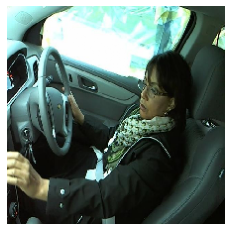

[[8.5352385e-06 3.5249471e-07 8.1295326e-07 6.9455462e-05 1.0774654e-05
  9.9985731e-01 1.2656337e-08 1.1052200e-06 5.0610845e-07 5.1230338e-05]]
[[8.5352384e-04 3.5249472e-05 8.1295329e-05 6.9455463e-03 1.0774654e-03
  9.9985733e+01 1.2656337e-06 1.1052200e-04 5.0610844e-05 5.1230337e-03]]
[8.5352384e-04 3.5249472e-05 8.1295329e-05 6.9455463e-03 1.0774654e-03
 9.9985733e+01 1.2656337e-06 1.1052200e-04 5.0610844e-05 5.1230337e-03]
c5
operating the radio


In [28]:
from keras.models import load_model
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import os


def load_image(img_path, show=True):
    img_clr = image.load_img(img_path, target_size=(220,220,3))
    img_tensor_0 = image.img_to_array(img_clr)                    # (height, width, channels)
    img_tensor_0 = np.expand_dims(img_tensor_0, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor_0 /= 255.
    
    img = cv2.imread(img_path, 0)
    img = cv2.resize(img, (128,128))
    #img = image.load_img(img_path, target_size=(64,64,1))
    img_tensor = image.img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor /= 255.                                      # imshow expects values in the range [0, 1]

    if show:
        plt.imshow(img_tensor_0[0])                           
        plt.axis('off')
        plt.show()

    return img_tensor

if __name__ == "__main__":

    # load model
    new_model = load_model("trained_CNN_model_4.h5")
    
        

    # image path
    img_path = 'E:/state-farm-distracted-driver-detection_1/imgs/test/img_1.jpg'    # dog
    #img_path = '/media/data/dogscats/test1/19.jpg'      # cat

    # load a single image
    new_image = load_image(img_path)

    # check prediction
    classes = new_model.predict(new_image)
    print(classes)
    
classes = classes*100
print(classes)
classes = classes[0]
print(classes)
maximum = max(classes)
classes_labels = ['safe driving','texting - right','talking on the phone - right','texting - left','talking on the phone - left','operating the radio','drinking','reaching behind','hair and makeup','talking to passenger']

for i in range(0,len(classes)):
    if (classes[i] == maximum):
        print('c'+str(i))
        print(classes_labels[i])


In [29]:
val_image = []
clean_image = []


files = sorted(os.listdir('E:/state-farm-distracted-driver-detection_1/New folder1/'))
for i in range(0,len(files)):
    img = cv2.imread('E:/state-farm-distracted-driver-detection_1/New folder1/'+files[i])
    clean_image.append(img)
    img = img[50:,120:-50]
    img = cv2.resize(img,(224,224))
    val_image.append(img)

print('All images are loaded')


All images are loaded


In [30]:
print(len(clean_image))
print(len(files))

45
45


In [31]:
def load_test_new(img_rows, img_cols, color_type=1):
    print('Read test images')
    start_time = time.time()
    path = os.path.join('E:','state-farm-distracted-driver-detection_1','New folder1','*.jpg')
    files = glob.glob(path)
    X_test = []
    X_test_id = []
    total = 0
    thr = math.floor(len(files)/10)
    print(thr)
    for fl in files:
        flbase = os.path.basename(fl)
        img = get_im_cv2_mod(fl, img_rows, img_cols, color_type)
        X_test.append(img)
        X_test_id.append(flbase)
        total += 1
        
    
    print('Read test data time: {} seconds'.format(round(time.time() - start_time, 2)))
    return X_test, X_test_id

In [32]:
def read_and_normalize_test_data_new(img_rows, img_cols, color_type=1):
    cache_path = os.path.join('cache', 'test_r_' + str(img_rows) + '_c_' + str(img_cols) + '_t_' + str(color_type) + '.dat')
    if not os.path.isfile(cache_path) or use_cache == 0:
        test_data, test_id = load_test_new(img_rows, img_cols, color_type)
        cache_data((test_data, test_id), cache_path)
    else:
        print('Restore test from cache!')
        (test_data, test_id) = restore_data(cache_path)

    test_data = np.array(test_data, dtype=np.uint8)
    test_data = test_data.reshape(test_data.shape[0], img_rows, img_cols, color_type)
    test_data = test_data.astype('float32')
    test_data /= 255
    print('Test shape:', test_data.shape)
    print(test_data.shape[0], 'test samples')
    return test_data, test_id

In [33]:
X_test, X_test_id = read_and_normalize_test_data_new(128,128, color_type=1)

Read test images
4
Read test data time: 0.43 seconds
Directory doesnt exists
Test shape: (45, 128, 128, 1)
45 test samples


In [34]:
print(len(X_test))
print(len(X_test[0]))

45
128


In [35]:
full_test_prediction = []


test_prediction = new_model.predict(X_test)
full_test_prediction.append(test_prediction)


In [36]:
print((full_test_prediction))
print((full_test_prediction[0]))
print(len(full_test_prediction[0]))

[array([[8.25809598e-01, 2.17415974e-03, 5.36855590e-03, 1.80135120e-03,
        4.60941636e-04, 7.58731812e-02, 6.67632418e-03, 1.45558668e-02,
        2.48195953e-03, 6.47980198e-02],
       [9.08857167e-01, 5.00911521e-03, 1.14259077e-02, 3.18617420e-03,
        1.72145367e-02, 2.85771117e-02, 9.51497164e-03, 6.66619139e-03,
        1.12291717e-03, 8.42604041e-03],
       [9.55978513e-01, 8.27330351e-03, 4.05610586e-03, 9.66279040e-05,
        1.26116176e-03, 9.69116855e-03, 1.01907747e-02, 3.42022185e-03,
        1.83873097e-04, 6.84825331e-03],
       [7.46325552e-01, 1.16186151e-02, 4.20050286e-02, 4.11026459e-03,
        4.43370007e-02, 3.91592756e-02, 5.23230508e-02, 3.65223922e-02,
        4.12206259e-03, 1.94767620e-02],
       [8.18349540e-01, 1.24508683e-02, 1.45262321e-02, 5.28213428e-03,
        2.98973471e-02, 6.41178042e-02, 2.42227986e-02, 1.34552941e-02,
        1.01667305e-03, 1.66814681e-02],
       [2.26441320e-04, 9.92138207e-01, 5.32371690e-04, 9.89928842e-04,
  

In [37]:
tags = { "C0": "safe driving",
"C1": "texting - left",
"C2": "On the phone - left",
"C3": "texting - right",
"C4": "On the phone - right",
"C5": "operating the radio",
"C6": "drinking",
"C7": "reaching behind",
"C8": "hair and makeup",
"C9": "talking to passenger" }

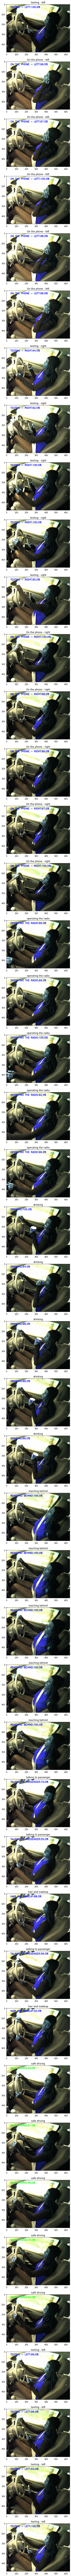

In [38]:
i = 0
tags_previous = ''
cntr = 0
#fig, ax = plt.subplots(20, 1, figsize = (200,200))

fig, ax = plt.subplots(len(full_test_prediction[0]), 1, figsize = (240,240))

for i in range(0,len(full_test_prediction[0])):
#for i in range(40,60):
   
    predicted_class = 'C'+str(np.where(full_test_prediction[0][i] == np.amax(full_test_prediction[0][i]))[0][0])
    font = cv2.FONT_HERSHEY_SIMPLEX
    text = tags[predicted_class].upper()+':'+str(round(full_test_prediction[0][i].max()*100,0))+'%'
    if tags[predicted_class] != tags_previous:
        cntr = 0

    if tags[predicted_class] == 'safe driving':
        cv2.putText(clean_image[i],text,(40,35), font, 0.8 ,(0,256,0),2)
    else:
        if cntr >= 0:
            cv2.putText(clean_image[i],text,(40,35), font, 0.8 ,(0,0,256),2)
        else:
            text = str(cntr+1)
            cntr = cntr+1
            print('came here')
            cv2.putText(clean_image[i],text,(40,35), font, 0.8 ,(0,0,256),2)

    tags_previous = tags[predicted_class]

    j = i-9 
    ax[j].imshow(clean_image[i].squeeze())
    ax[j].set_title(tags[predicted_class])

    plt.show
    

In [ ]:
i = 0
tags_previous = ''
cntr = 0
#fig, ax = plt.subplots(20, 1, figsize = (200,200))

fig, ax = plt.subplots(len(full_test_prediction[0]), 1, figsize = (240,240))

for i in range(0,len(full_test_prediction[0])):
#for i in range(40,60):
   
    predicted_class = 'C'+str(np.where(full_test_prediction[0][i] == np.amax(full_test_prediction[0][i]))[0][0])
    font = cv2.FONT_HERSHEY_SIMPLEX
    text = tags[predicted_class].upper()+':'+str(round(full_test_prediction[0][i].max()*100,0))+'%'
    if tags[predicted_class] != tags_previous:
        cntr = 0

    if tags[predicted_class] == 'safe driving':
        cv2.putText(clean_image[i],text,(40,35), font, 0.8 ,(0,256,0),2)
    else:
        if cntr >= 0:
            cv2.putText(clean_image[i],text,(40,35), font, 0.8 ,(0,0,256),2)
        else:
            text = str(cntr+1)
            cntr = cntr+1
            print('came here')
            cv2.putText(clean_image[i],text,(40,35), font, 0.8 ,(0,0,256),2)

    tags_previous = tags[predicted_class]

    j = i-9 
    ax[j].imshow(clean_image[i].squeeze())
    ax[j].set_title(tags[predicted_class])

    plt.show
    

In [39]:
out = cv2.VideoWriter('Ensembled_Predictedvideo New.mp4',cv2.VideoWriter_fourcc(*'DIVX'), 3, (640,480))
 
for i in range(len(clean_image)):
    out.write(clean_image[i])
out.release()